<a href="https://colab.research.google.com/github/Bumble-beee/Handout_Smart_Sensing_Feb2026/blob/main/Thermal_Spot_v3_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LHS Sensor Layout Generated: [(0, 0), (1, 3), (2, 4), (3, 6), (4, 1), (5, 5), (6, 2)]


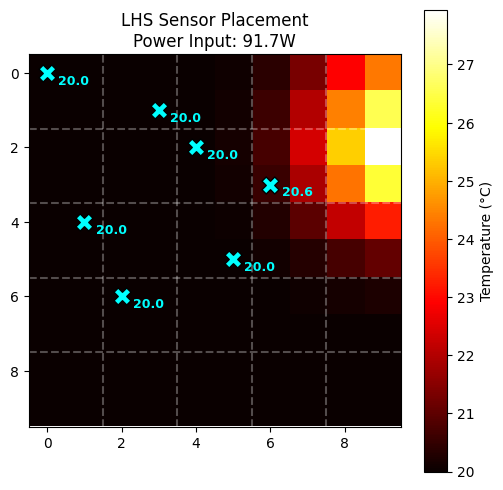

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import gaussian_filter
nr_sensors = 7

# --- 1. Latin Hypercube Sampling Logic ---
def get_latin_hypercube_sensors(grid_size=10, n_sensors=5):
    """
    Generates sensor coordinates using Latin Hypercube logic.
    Ensures that if you project the sensors onto the X or Y axis,
    they are evenly distributed (no clustering).
    """
    # Calculate the width of each 'stratum' (slice)
    stride = grid_size // n_sensors

    # Generate Row Indices and Col Indices
    row_indices = [np.random.randint(i*stride, (i+1)*stride) for i in range(n_sensors)]
    col_indices = [np.random.randint(i*stride, (i+1)*stride) for i in range(n_sensors)]

    # Shuffle columns to break diagonal correlation
    np.random.shuffle(col_indices)

    return list(zip(row_indices, col_indices))

# --- 2. Data Generation ---
def generate_thermal_data(n_samples=1000, grid_size=10):

    # Generate the LHS sensor layout ONCE
    sensors = get_latin_hypercube_sensors(grid_size, n_sensors=nr_sensors)
    print(f"LHS Sensor Layout Generated: {sensors}")

    X = []
    Y = []

    for _ in range(n_samples):
        # Initialize board
        heat_map = np.zeros((grid_size, grid_size)) + 20.0 # Ambient Temp.

        # Generate a random "CPU Power" load (The Fusion Variable)
        # Power varies between 10W and 100W
        power_watts = np.random.uniform(10, 100)

        # Create random hotspots based on power
        # Higher power = hotter spots, more spots
        num_hotspots = np.random.randint(1, 4)

        for _ in range(num_hotspots):
            rx, ry = np.random.randint(0, grid_size, 2)
            # Heat intensity correlated with Power
            intensity = power_watts * np.random.uniform(0.5, 1.5)
            heat_map[rx, ry] += intensity

        # Apply Diffusion
        heat_map = gaussian_filter(heat_map, sigma=1.5)

        # Extract Sensor Readings
        sensor_readings = []
        for (sx, sy) in sensors:
            sensor_readings.append(heat_map[sx, sy])

        # Construct Vectors
        input_vector = sensor_readings + [power_watts]
        target_vector = heat_map.flatten()

        X.append(input_vector)
        Y.append(target_vector)

    return np.array(X), np.array(Y), sensors

# --- Run & Visualize ---
X_data, Y_data, sensors = generate_thermal_data(n_samples=nr_sensors)

sample_idx = 0
grid_size = 10
full_map = Y_data[sample_idx].reshape(grid_size, grid_size)
power_val = X_data[sample_idx][nr_sensors]

plt.figure(figsize=(6, 6))
plt.imshow(full_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Temperature (°C)')
plt.title(f"LHS Sensor Placement\nPower Input: {power_val:.1f}W")

# Visualize the Grid Strata
stride = grid_size // 5
for i in range(1, 5):
    plt.axhline(i*stride - 0.5, color='white', linestyle='--', alpha=0.3)
    plt.axvline(i*stride - 0.5, color='white', linestyle='--', alpha=0.3)

for i, (sx, sy) in enumerate(sensors):
    plt.scatter(sy, sx, c='cyan', marker='X', s=150, edgecolors='black')
    plt.text(sy+0.3, sx+0.3, f"{full_map[sx, sy]:.1f}", color='cyan', fontsize=9, fontweight='bold')

plt.show()